In [1]:
import io
from PIL import Image
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import json
import torch.utils.data as tdata
from tqdm import tqdm
from torch import optim 
import torch.nn as nn

from transformers.models.detr.feature_extraction_detr import rgb_to_id
from transformers import AutoImageProcessor, AutoModelForImageSegmentation

c:\Users\User\Desktop\ML\fine_tunning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#%pip install -qq -U diffusers datasets transformers accelerate ftfy 

#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

#%pip install timm

In [2]:
device= torch.device("cuda:0")
device

device(type='cuda', index=0)

In [3]:
WIDTH=1280
HEIGHT=720

In [4]:

processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = AutoModelForImageSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic").to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from datasets import load_dataset

data = load_dataset("DHPR/Driving-Hazard-Prediction-and-Reasoning")


Generating train split: 100%|██████████| 12975/12975 [00:02<00:00, 6344.55 examples/s]


In [82]:
class Dataset(tdata.Dataset):
    def __init__(self,dataset,processor):
        self.len=len(dataset)
        self.processor=processor

        self.image=[]
        self.bbox=[]
        self.mask=[]
        for data in dataset:
            self.image.append(data['image'])
            box=json.loads(data['bounding_box'])[0]
            ms=np.full((HEIGHT,WIDTH,3),0)
            for y in range(box[0],box[2]):
                for x in range(box[1],box[3]):
                    ms[x][y]=[1,1,1]
            self.mask.append(ms)
            box[0]/=WIDTH
            box[2]/=WIDTH
            box[1]/=HEIGHT
            box[3]/=HEIGHT
            self.bbox.append(box)
    
    def __getitem__(self, id):
        out=self.processor(images=self.image[id], return_tensors="pt")
        return  out,torch.tensor(self.bbox[id]).to(device)
    
    def getData(self,id):
        return self.image[id],self.bbox[id], self.mask[id]

    def __len__(self):
        return self.len
    


In [52]:

cnt=10

darray=[]
for dt in data['train']:
    if dt['image'].size == (WIDTH,HEIGHT):
        darray.append(dt)
        cnt-=1
        if cnt==0:
            break


darray

[{'question_id': '3',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
  'question': 'Based on my dashcam image, what is the potential hazard? Response: ',
  'hazard': 'we try to take a slight right turn but miss the angle and crash into Entity #1.',
  'bounding_box': '[[137, 0, 538, 334]]',
  'plausible_speed': '45 km/h',
  'image_source': '393a00d2-c5f13ce5'},
 {'question_id': '5',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
  'question': 'Based on my dashcam image, what is the potential hazard? Response: ',
  'hazard': 'Entity #1 slows down, does not take account of my speed, due to this won’t have time to stop and crash towards back of Entity #1',
  'bounding_box': '[[471, 433, 619, 577]]',
  'plausible_speed': '75+ km/h',
  'image_source': '65cb7a27-825ac139'},
 {'question_id': '7',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
  'question': 'Based on my dashcam image, what is the potential

In [83]:

train_dset=Dataset(darray,processor=processor)

len(train_dset)



10

tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], device='cuda:0', dtype=torch.int32)

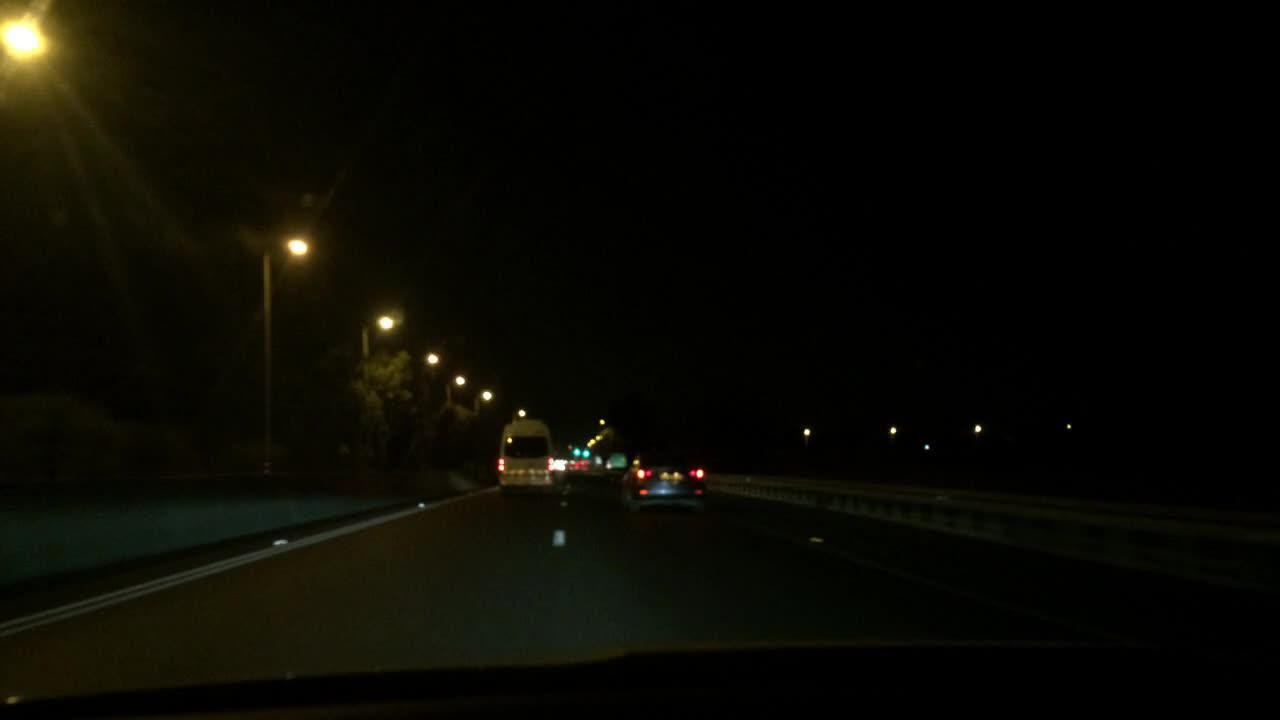

In [98]:
#Image.fromarray(np.uint8(train_dset[0][0].cpu().numpy()*255))
train_dset.getData(6)[0]

In [93]:
train_dset[1][1]

tensor([0.3680, 0.6014, 0.4836, 0.8014], device='cuda:0')

In [94]:
train_data=tdata.DataLoader(train_dset,batch_size=1)

In [ ]:
model

In [59]:
input=processor(train_dset.image[6],return_tensors="pt").to(device)
output=model(**input)


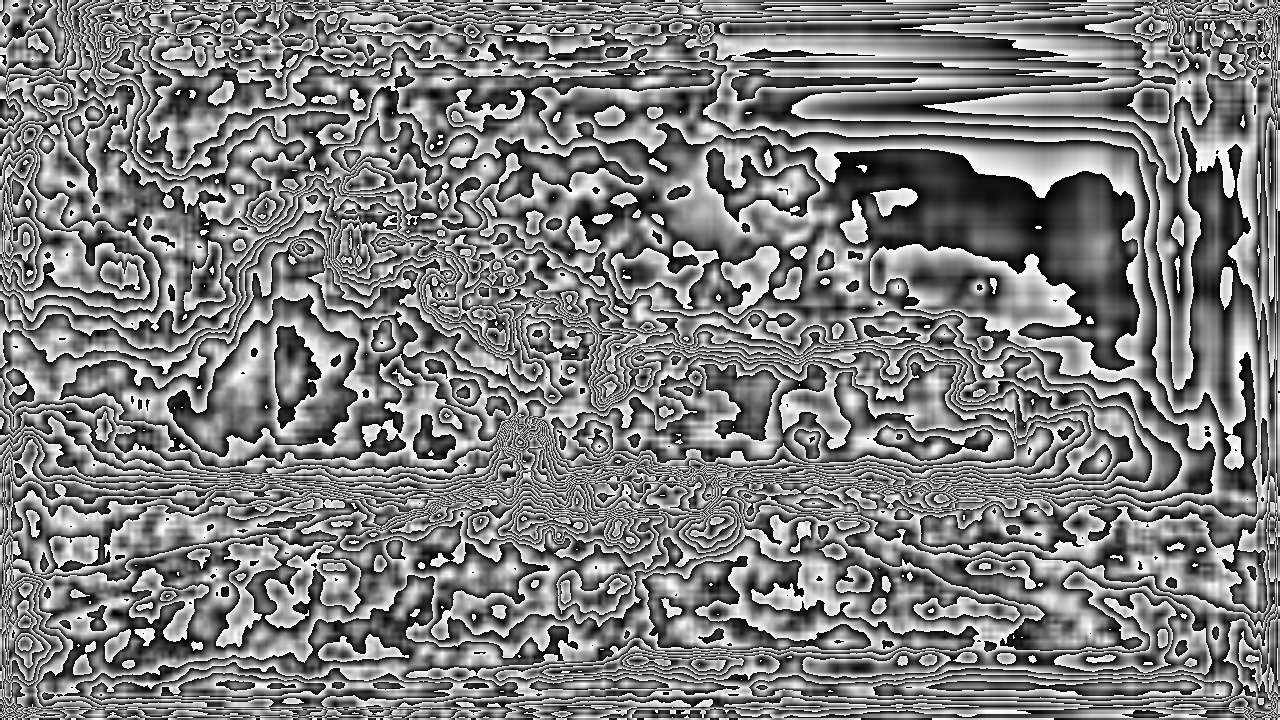

In [65]:
output.pred_masks.shape

predicted_masks = output.pred_masks.squeeze(1)
predicted_masks = nn.functional.interpolate(predicted_masks,
        size=(HEIGHT, WIDTH),
        mode='bilinear',
        align_corners=False)
predicted_masks.shape

Image.fromarray(np.uint8(predicted_masks[0][0].detach().cpu().numpy()*255))

In [ ]:
# boxes=output.pred_boxes.detach().cpu().numpy()[0]


# im=train_set.image[0]

# fig, ax = plt.subplots()

# ax.imshow(im)

# for box in boxes:
#     x=box[0]
#     y=box[1]
#     h=box[2]-x
#     w=box[3]-y
#     ax.add_patch(plt.Rectangle((x*1000,y*1800), h*1000, w*1800, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# plt.show()

In [ ]:
# processed_sizes = torch.as_tensor(input["pixel_values"].shape[-2:]).unsqueeze(0)
# result = processor.post_process_panoptic(output, processed_sizes)[0]

# # the segmentation is stored in a special-format png
# panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
# panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
# # retrieve the ids corresponding to each mask
# panoptic_seg_id = rgb_to_id(panoptic_seg)

# Image.fromarray(panoptic_seg)


In [66]:
optimizer=optim.Adam(model.parameters(),lr=0.0001)

criterion=nn.MSELoss()

100%|██████████| 10/10 [10:09<00:00, 60.90s/it]


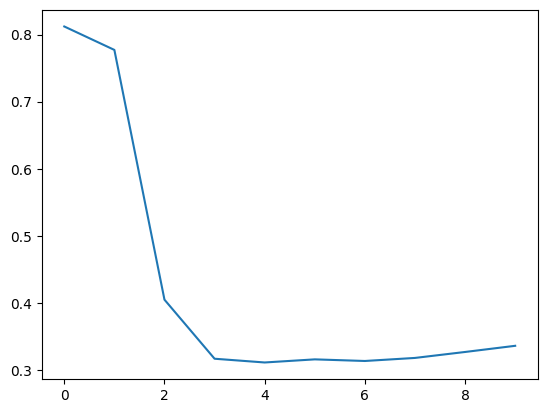

In [96]:
EPOCH=[]
LOSS=[]

for epoch in tqdm(range(10)):
    model.train()
    tloss=0
    for x,y in train_data:
        criterion.zero_grad()
        py= model(pixel_values=x["pixel_values"][0].to(device))

        predicted_masks = py.pred_masks.squeeze(1)
        predicted_masks = nn.functional.interpolate(predicted_masks,
                size=(HEIGHT, WIDTH),
                mode='bilinear',
                align_corners=False)
        
        loss=criterion(py.pred_boxes[0][0],y[0])
        loss.backward()
        optimizer.step()

        tloss+=loss.item()

    EPOCH.append(epoch)
    LOSS.append(tloss)
   

plt.plot(EPOCH,LOSS)

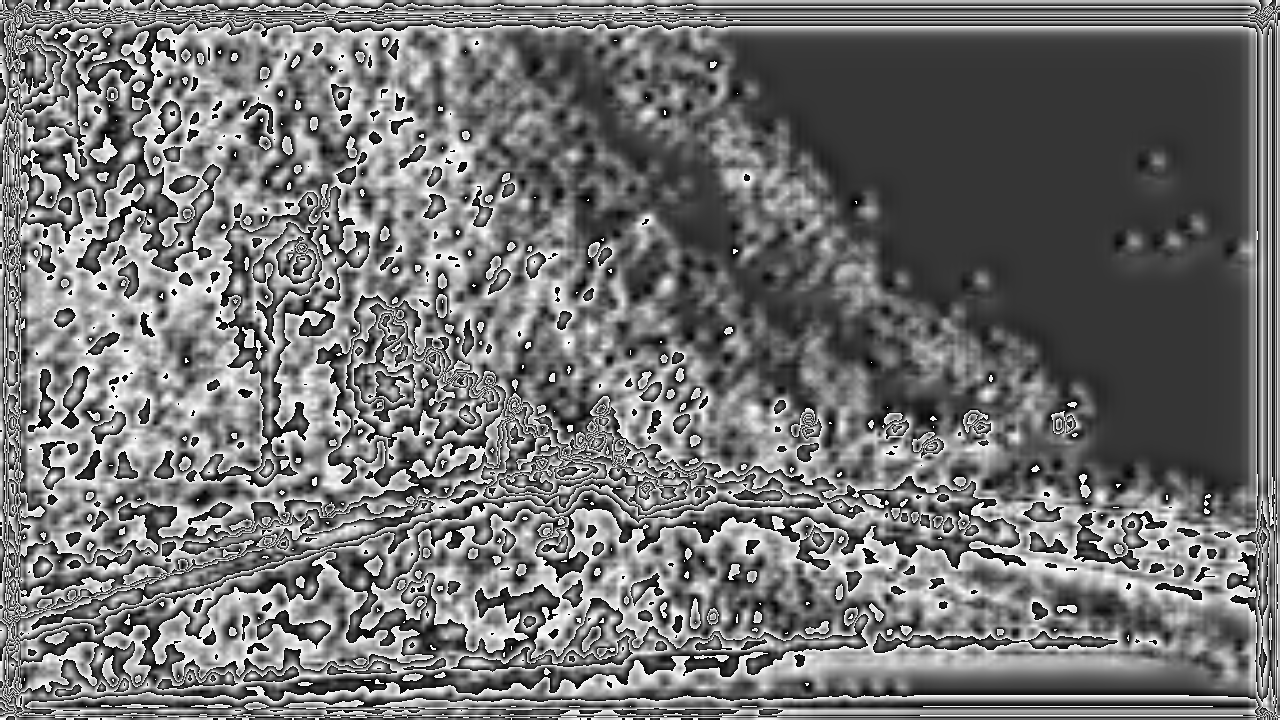

In [97]:
input=processor(train_dset.image[6],return_tensors="pt").to(device)
output=model(**input)

output.pred_masks.shape

predicted_masks = output.pred_masks.squeeze(1)
predicted_masks = nn.functional.interpolate(predicted_masks,
        size=(HEIGHT, WIDTH),
        mode='bilinear',
        align_corners=False)
predicted_masks.shape

Image.fromarray(np.uint8(predicted_masks[0][0].detach().cpu().numpy()*255))